In [1]:
#Shishir Khanal
#CMU-Optimal Controls from Jack Manchester
#Regularization

In [2]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate();

Pkg.add("LinearAlgebra");
Pkg.add("PyPlot");
Pkg.add("ForwardDiff");

using LinearAlgebra;
using PyPlot;
using ForwardDiff;

  Activating project at `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints/Manifest.toml`


In [13]:
Q = Diagonal([0.5; 1])
#Quadratic Objective Function
function f(x)
    return 0.5*(x-[1; 0])'*Q*(x-[1; 0])
end

function ∇f(x)
    return Q*(x-[1; 0])
end

function ∇2f(x)
    return Q
end

∇2f (generic function with 1 method)

In [14]:
#Quadratic Constraint
function c(x)
    return x[1]^2 + 2*x[1] - x[2]
end

#Jacobian of Constraint
function δc(x)
    return [2*x[1]+2 -1]
end

δc (generic function with 1 method)

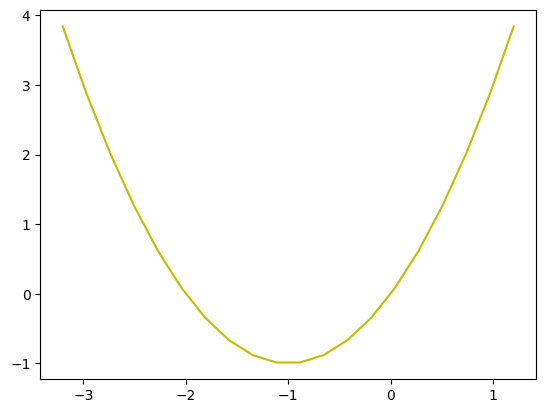

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0fb93795b0>

In [15]:
function plot_landscape()
    Nsamp = 20
    Xsamp = kron(ones(Nsamp), LinRange(-4,4,Nsamp)')
    Ysamp = kron(ones(Nsamp)', LinRange(-4,4,Nsamp))
    Zsamp = zeros(Nsamp, Nsamp)
    for j = 1:Nsamp
        for k = 1:Nsamp
            Zsamp[j,k] = f([Xsamp[j,k]; Ysamp[j,k]])
        end
    end
    #positive definite hessian so level curve looks like a bowl
    #contour(Xsamp, Ysamp, Zsamp)
    
    xc = LinRange(-3.2, 1.2, Nsamp)
    #Quadratic Equality Constraint
    plot(xc, xc.^2+2.0.*xc, "y")
end

plot_landscape()

In [16]:
function newton_step(x, λ)
    H = ∇2f(x) + ForwardDiff.jacobian(xn -> δc(xn)'*λ, x)
    C = δc(x)
    K = [H C'; C 0]
    Δz = K\[-∇f(x)-C'*λ; -c(x)]
    Δx = Δz[1:2]
    Δλ = Δz[3]
    return Δx, Δλ
end

newton_step (generic function with 1 method)

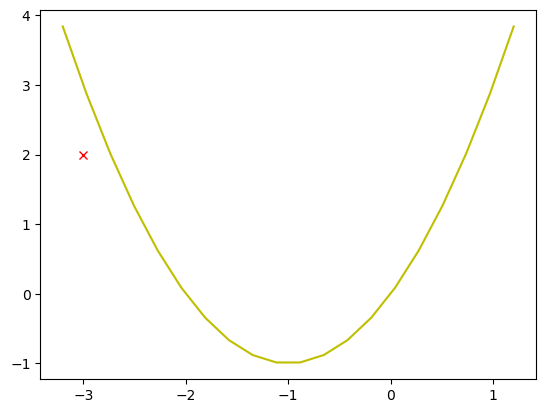

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0fb9367c70>

In [17]:
xguess = [-3; 2]
λguess = [0.0]
plot_landscape()
plot(xguess[1], xguess[2], "rx")

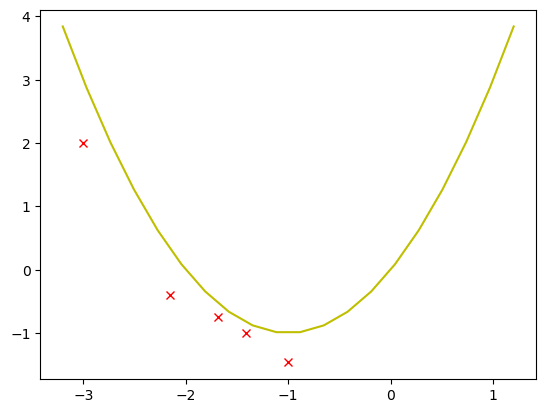

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0fb91a6460>

In [22]:
#4 runs
Δx, Δλ = newton_step(xguess[:,end], λguess[end])
xguess = [xguess xguess[:,end]+Δx]
λguess = [λguess λguess[end]+Δλ]
plot_landscape()
plot(xguess[1,:], xguess[2,:], "rx")

In [23]:
H = ∇2f(xguess[:,end]) + ForwardDiff.jacobian(xn -> δc(xn)'*λguess[end], xguess[:,end])
C = δc(xguess[:, end])
K = [H C'; C 0]
# X is 2D, constraint is 1D.KKT system is 3x3. 3 eigvals.Hence, 2 +ve evals and 1 -ve evals
#however we gey 2 negatives 1 positive which is wrong
eigvals(K)

3-element Vector{Float64}:
 -1.923496856374468
 -0.2492953085600365
  1.6819819715798108

In [24]:
function regularized_newton_step(x, λ)
    H = ∇2f(x) + ForwardDiff.jacobian(xn -> δc(xn)'*λ, x)
    C = δc(x)
    K = [H C'; C 0]
    e = eigvals(K)
    #not a good approach in real life: computing eigenvalues in realtime is super expensive
    #Do it as long as the eigenvalues are wrong
    while !(sum(e .> 0) == length(x) && sum(e .< 0) == length(λ))
        #add positive regularization to x dimension: ones(length(x))
        #add negative regularization to the λ dimension
        K = K + Diagonal([ones(length(x)); -ones(length(λ))])
        e = eigvals(K)
    end
    Δz = K\[-∇f(x)-C'*λ; -c(x)]
    Δx = Δz[1:2]
    Δλ = Δz[3]
    return Δx,Δλ
end

regularized_newton_step (generic function with 1 method)

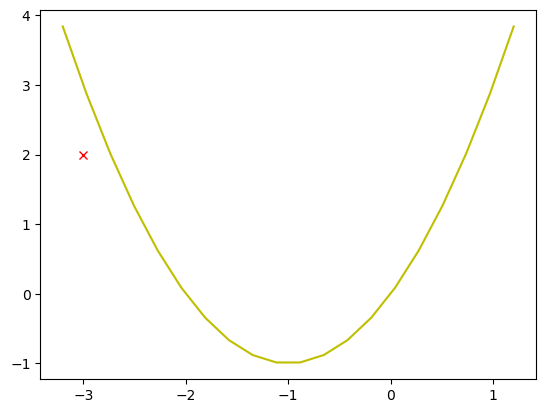

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0fb91127f0>

In [25]:
xguess = [-3; 2]
λguess = [0.0]
plot_landscape()
plot(xguess[1], xguess[2], "rx")

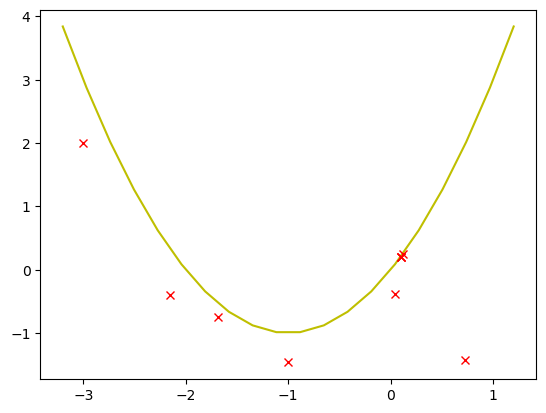

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0fb8d30070>

In [34]:
Δx, Δλ = regularized_newton_step(xguess[:,end],λguess[end])
xguess = [xguess xguess[:,end]+Δx]
λguess = [λguess λguess[end]+Δλ]
plot_landscape()
plot(xguess[1,:], xguess[2,:], "rx")
#During the convergence, we overshot and went pretty far of the constraint manifold
#We want to stay closer and track the constraint better
#next step: Line search with constraint